## Classification

In [14]:
import torch
import torch.utils.data
import torch.utils.data as data_utils
import torchvision.transforms as T
import pickle as pkl
import pandas as pd
import torch
import torchvision
from tqdm import tqdm
from importlib import import_module
import shutil
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from torch.nn.utils.rnn import pad_sequence
import pickle as pkl
import cv2
import logging
import math
import functools
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter as P

class CustomDataset(data_utils.Dataset):
 
    def __init__(self,aug = False):
        with open("/kaggle/input/dataset-cs114/dataset (1).pkl", "rb") as f:
            data = pkl.load(f)

        self.word_data = data["data"]
        self.idx_to_id = {i: w_id for i, w_id in enumerate(self.word_data.keys())}
     
        if aug:
            self.transform = T.Compose([
                    T.Resize((128,128)),
                    T.RandomChoice([
                        T.ColorJitter(0.2, 0.2),
                        T.GaussianBlur(3),
                        T.RandomAdjustSharpness(2),
                        T.RandomRotation(degrees=15)

                    ]),
                    T.ToTensor() 
                ])
        else:
            self.transform = T.Compose([
                    T.Resize((128,128)),
                    T.ToTensor(),
                    T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])   
                    
                ])
        
         
    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        item = {}
        w_id = self.idx_to_id[idx]

        # Get image and label
        lab, img = self.word_data[w_id]
      
        img =   self.transform(img)

        item["img"] = img.float()
        item["label"] = torch.tensor(lab)


        return item

dataset = CustomDataset()
aug_dataset = CustomDataset(aug = True)
 
 


In [2]:
from torch.utils.data import ConcatDataset
final_dataset = ConcatDataset([aug_dataset, dataset])

In [3]:
print(len(final_dataset))

12296


In [3]:
from torch.utils.data import random_split
 
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

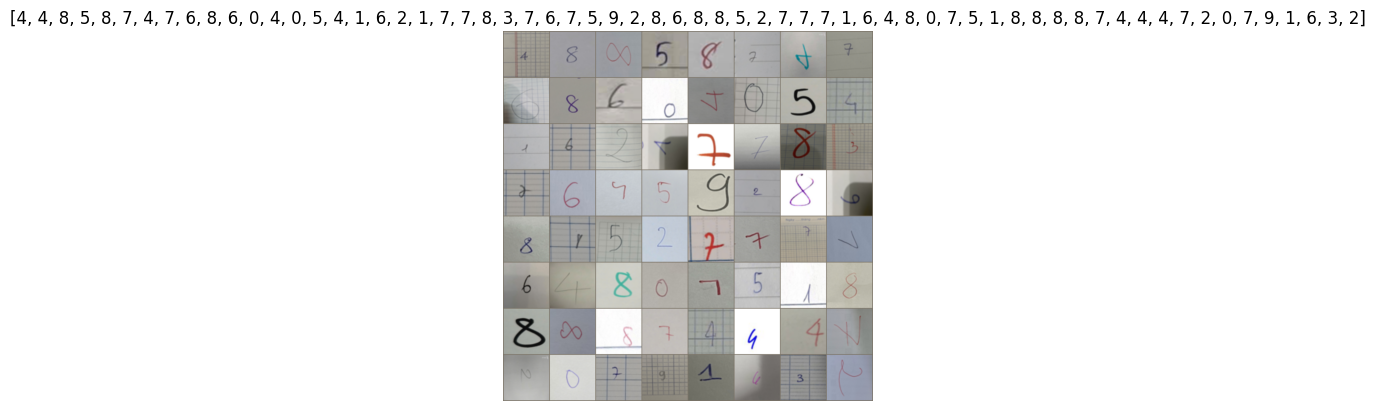

In [6]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor
 
def imshow(inp, title=None):   
    inp = inp.numpy()
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()
 
batch = next(iter(train_loader))
inputs = batch["img"]
classes = batch["label"]
 
out = torchvision.utils.make_grid(inputs)

 
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
out = unnormalize(out.clone(), mean, std)
 
imshow(out, title=[int(x) for x in classes])

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [8]:
device = "cuda"
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 86.1MB/s]


In [9]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        best_loss = 999
        cnt_stop = 0
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch in tqdm(train_loader):
                    inputs = batch["img"].to(device)
                    labels = batch["label"].to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item()
     
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(train_loader)
                if epoch_loss < best_loss:
                    torch.save(model.state_dict(), best_model_params_path)
                    best_loss = epoch_loss
                    cnt_stop = 0
                else:
                    cnt_stop += 1
                if cnt_stop>=5:
                    return model

                print(f'{phase} Loss: {epoch_loss:.4f}')

              
    return model

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------


100%|██████████| 77/77 [00:09<00:00,  8.28it/s]


train Loss: 1.7508
Epoch 1/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.05it/s]


train Loss: 0.6536
Epoch 2/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.82it/s]


train Loss: 0.3277
Epoch 3/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.11it/s]


train Loss: 0.2012
Epoch 4/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.91it/s]


train Loss: 0.1325
Epoch 5/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.60it/s]


train Loss: 0.0984
Epoch 6/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.04it/s]


train Loss: 0.0815
Epoch 7/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.08it/s]


train Loss: 0.0652
Epoch 8/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.12it/s]


train Loss: 0.0633
Epoch 9/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.84it/s]


train Loss: 0.0626
Epoch 10/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.03it/s]


train Loss: 0.0615
Epoch 11/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.66it/s]


train Loss: 0.0599
Epoch 12/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.09it/s]


train Loss: 0.0591
Epoch 13/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.93it/s]


train Loss: 0.0576
Epoch 14/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.87it/s]


train Loss: 0.0574
Epoch 15/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.87it/s]


train Loss: 0.0589
Epoch 16/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.87it/s]


train Loss: 0.0558
Epoch 17/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.80it/s]


train Loss: 0.0595
Epoch 18/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.88it/s]


train Loss: 0.0579
Epoch 19/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.87it/s]


train Loss: 0.0584
Epoch 20/49
----------


100%|██████████| 77/77 [00:05<00:00, 13.92it/s]


train Loss: 0.0599
Epoch 21/49
----------


100%|██████████| 77/77 [00:05<00:00, 14.03it/s]


In [12]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        inputs = batch["img"].to(device)
        labels = batch["label"].to(device)
        
        outputs =model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 20/20 [00:01<00:00, 18.13it/s]


In [13]:
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))

Test Accuracy: 0.9
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       123
           1       0.96      0.89      0.92       124
           2       0.82      0.88      0.85       115
           3       0.84      0.91      0.87       118
           4       0.91      0.89      0.90       130
           5       0.95      0.91      0.93       140
           6       0.91      0.92      0.91       123
           7       0.93      0.93      0.93       120
           8       0.88      0.87      0.88       114
           9       0.88      0.85      0.86       123

    accuracy                           0.90      1230
   macro avg       0.90      0.90      0.90      1230
weighted avg       0.90      0.90      0.90      1230

